<a href="https://colab.research.google.com/github/BhadrinathKS/Brain-Tumor-Detection/blob/main/BrainTumorDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection

Author: Bhadrinath Kolluru

Date: July 19th, 2024

# 1) Project Overview & Objectives

The purpose of this project is to build a CNN model that can classify if a brain has a tumor or not based off various MRI scans.

Objectives:
1. Image Files will be split into datasets
2. All MRI scans will be cropped and resized for the model
3. Create Model using Tensorflow & Keras
4. Data Augmentation for more accuracy in the model
5. Split Data Augmented images into Training set, Testing Set & Validation Set
6. Be able to classify if an MRI scan is Tumorous or Non-Tumorous from Validation set

# 2) Import Libraries & Connect Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/drive/My\ Drive/ /Gdrive
!ls /Gdrive

Mounted at /content/drive
 brain_tumor_Detector.h5   BTDv2  'Colab Notebooks'   MachineLearningProject   model.h5  'My Drive'


In [2]:
# Import Libraries
import os, shutil
import cv2
import glob
import imutils
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Import Keras (Sequential Machine Learning Model)
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 3) Image Renaming & EDA

In [ ]:
# Renaming all Files

# Yes Directory
tumerous = '/Gdrive/BTDv2/images/datasets/yes/'
countY = 1

for filename in os.listdir(tumerous):
    source = tumerous + filename
    destination = tumerous + "Y_" +str(countY)+".jpg"
    os.rename(source, destination)
    countY+=1
print("All files are renamed in the Yes Directory!\n")

print(". . .\n")

# No Directory
non_tumerous = '/Gdrive/BTDv2/images/datasets/no/'
countN = 1

for filename in os.listdir(non_tumerous):
    source = non_tumerous + filename
    destination = non_tumerous +"N_" +str(countN)+".jpg"
    os.rename(source, destination)
    countN+=1
print("All files are renamed in the No Directory")

All files are renamed in the Yes Directory!

. . .

All files are renamed in the No Directory


In [ ]:
# EDA (Exploratory Data Analysis)

Ylist = os.listdir("/Gdrive/BTDv2/images/datasets/yes/")
number_files_yes = len(Ylist)
print("Yes Files: "+str(number_files_yes))


Nlist = os.listdir("/Gdrive/BTDv2/images/datasets/no/")
number_files_no = len(Nlist)
print("No Files: "+str(number_files_no))

Yes Files: 155
No Files: 98


# 4) Data Visualization on chosen sample

Text(0.5, 1.0, 'Count of Tumerous Brain Images')

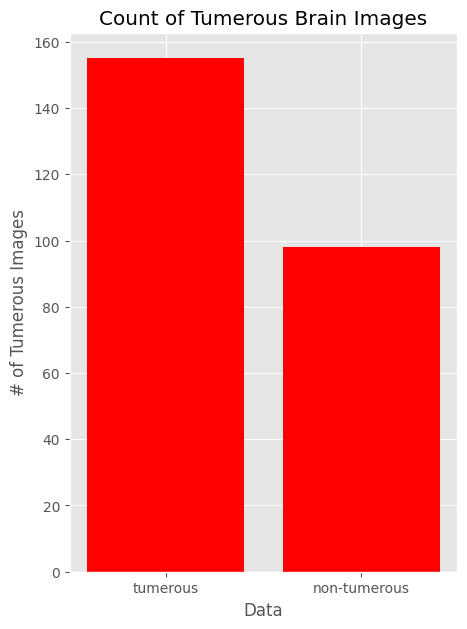

In [ ]:
# Plot Of Original Sample

data = {'tumerous': number_files_yes, 'non-tumerous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("# of Tumerous Images")
plt.title("Count of Tumerous Brain Images")

# 5) Data Augmentation

In [ ]:
# Create Timer
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [ ]:
# 155(61%), 98(39%)
# There is an imbalance in the sample so it is important to create more images to increase accuracy of the model

def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
# Augmentation Start
import time
start_time = time.time()

yes_path = '/Gdrive/BTDv2/images/datasets/yes/'
no_path = '/Gdrive/BTDv2/images/datasets/no/'
augmented_data_path = '/Gdrive/BTDv2/data/augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=2, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=4, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print("Sucessful Augmentation!\n")
print(timing(execution_time))

Sucessful Augmentation!

0:1:42.39773774147034


In [ ]:
# EDA (Exploratory Data Analysis) - Post Augmentation

Ylist = os.listdir("/Gdrive/MachineLearningProject/data/augmented_data/yes/")
number_files_yes = len(Ylist)
print("Yes Files: "+str(number_files_yes))


Nlist = os.listdir("/Gdrive/MachineLearningProject/data/augmented_data/no/")
number_files_no = len(Nlist)
print("No Files: "+str(number_files_no))

Yes Files: 424
No Files: 490


In [ ]:
# Post-Augmentation Results

def data_summary(main_path):
    yes_path = "/Gdrive/BTDv2/data/augmented_data/yes/"
    no_path = "/Gdrive/BTDv2/data/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    n = (n_pos + n_neg)
    pos_per = (n_pos*100/n)
    neg_per = (n_neg*100/n)

    print(f"Number of samples: {n}")
    print(f"Number of positive samples: {n_pos} ({pos_per}%)")
    print(f"Number of negative samples: {n_neg} ({neg_per}%)")

# Show Summary
data_summary(augmented_data_path)

Number of samples: 955
Number of positive samples: 465 (48.69109947643979%)
Number of negative samples: 490 (51.30890052356021%)


Text(0.5, 1.0, 'Count of Tumerous Brain Images')

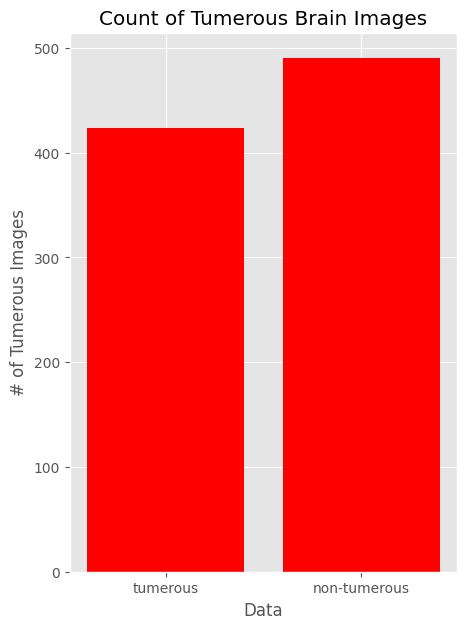

In [ ]:
# New Plot

data = {'tumerous': number_files_yes, 'non-tumerous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("# of Tumerous Images")
plt.title("Count of Tumerous Brain Images")

# 7) Data Preprocessing

In [ ]:
# Convert BGR to GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [ ]:
def crop_brain_tumor(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

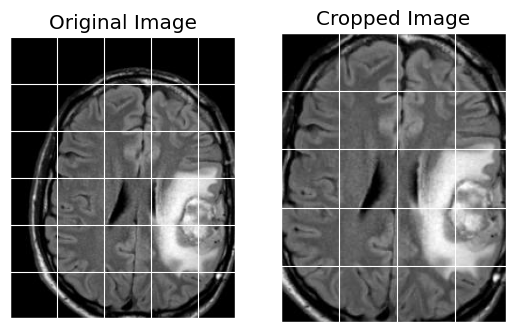

In [ ]:
# Tumerous MRI Scan Cropped
img = cv2.imread('/Gdrive/MachineLearningProject/data/augmented_data/yes/aug_Y_15_0_1197.jpg')
crop_brain_tumor(img, True)

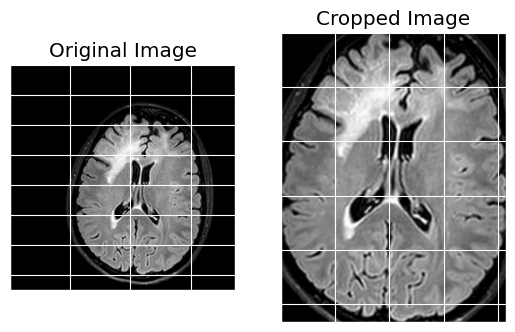

In [ ]:
# Non-Tumerous MRI Scan Cropped
img = cv2.imread('/Gdrive/MachineLearningProject/data/augmented_data/no/aug_N_38_0_3762.jpg')
crop_brain_tumor(img, True)

# 8) Image Resizing

In [ ]:
from sklearn.utils import shuffle
import cv2
import os
import numpy as np

augmeneted_yes = '/Gdrive/BTDv2/data/augmented_data/yes/'
augmeneted_no = '/Gdrive/BTDv2/data/augmented_data/no/'

tumerous=[]
non_tumerous=[]

for filename in os.listdir(augmeneted_yes):
    img = cv2.imread(augmeneted_yes + '/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    tumerous.append((img,1))
print("Tumerous Images Resized!")

for filename in os.listdir(augmeneted_no):
    img = cv2.imread(augmeneted_no + '/' + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    non_tumerous.append((img,0))
print("Non-Tumerous Images Resized!")

all_data = tumerous + non_tumerous
all_data = shuffle(all_data)

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

Tumerous Images Resized!
Non-Tumerous Images Resized!


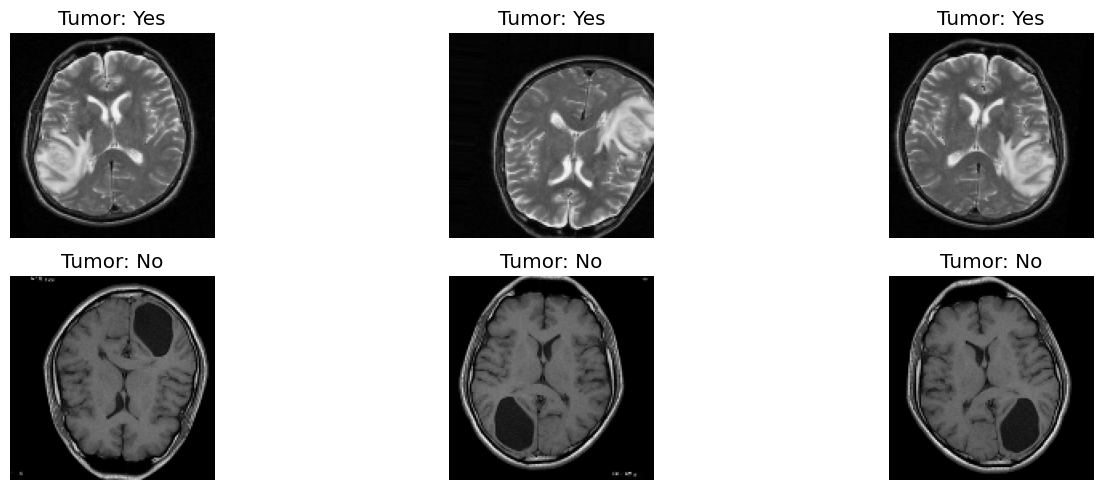

In [ ]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumerous[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(non_tumerous[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 9) Data Scaling & Transformation

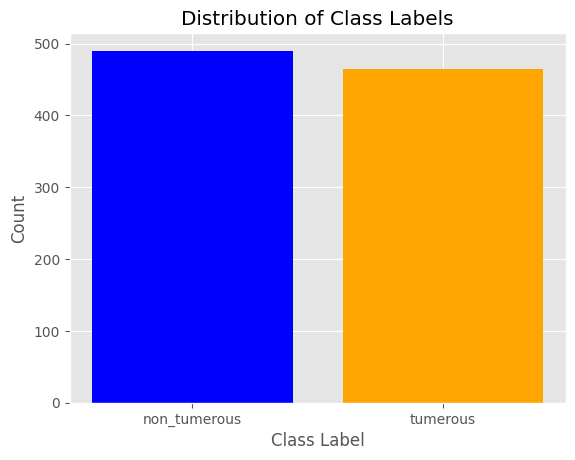

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['non_tumerous', 'tumerous'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [ ]:
x_train= x_train /255.0
x_test = x_test / 255.0

In [ ]:
print("Minimum value of the scaled data:", x_train.min())
print("Maximum value of the scaled data:",  x_train.max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


# 10) Building the CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

# 11) Training the CNN Model

In [ ]:
# Callback Function

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

back = myCallback()

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data = (x_test,y_test),
                    callbacks=[back])

Epoch 1/100
24/24 [==============================] - 31s 1s/step - loss: 0.4847 - accuracy: 0.7814 - val_loss: 0.4116 - val_accuracy: 0.7908
Epoch 2/100
24/24 [==============================] - 32s 1s/step - loss: 0.4454 - accuracy: 0.8050 - val_loss: 0.7642 - val_accuracy: 0.6667
Epoch 3/100
24/24 [==============================] - 33s 1s/step - loss: 0.4487 - accuracy: 0.7840 - val_loss: 0.3510 - val_accuracy: 0.7974
Epoch 4/100
24/24 [==============================] - 28s 1s/step - loss: 0.4024 - accuracy: 0.8194 - val_loss: 0.3879 - val_accuracy: 0.8105
Epoch 5/100
24/24 [==============================] - 34s 1s/step - loss: 0.3502 - accuracy: 0.8455 - val_loss: 0.2598 - val_accuracy: 0.8824
Epoch 6/100
24/24 [==============================] - 23s 979ms/step - loss: 0.3202 - accuracy: 0.8639 - val_loss: 0.2242 - val_accuracy: 0.9020
Epoch 7/100
24/24 [==============================] - 25s 1s/step - loss: 0.2640 - accuracy: 0.8757 - val_loss: 0.1728 - val_accuracy: 0.9412
Epoch 8/10

In [ ]:
# Achieved 99% Accuracy!

# 12) Plot of Model Loss over Epochs

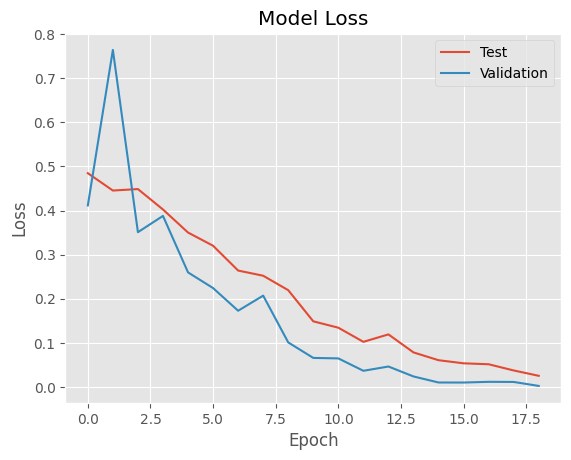

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

# 13) Creating Validation Set

In [8]:
# Creating the Validation Set

if not os.path.isdir('/Gdrive/BTDv2/data/tumerous_and_nontumerous/'):
  base_dir = '/Gdrive/BTDv2/data/tumerous_and_nontumerous/'
  os.mkdir(base_dir)

if not os.path.isdir('/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation'):
  validation_dir = os.path.join(base_dir + 'validation')
  os.mkdir(validation_dir)

if not os.path.isdir('/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation/tumerous'):
  infected_validation_dir = os.path.join(validation_dir, 'tumerous')
  os.mkdir(infected_validation_dir)

if not os.path.isdir('/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation/non_tumerous'):
  healthy_validation_dir = os.path.join(validation_dir, 'non_tumerous')
  os.mkdir(healthy_validation_dir)

In [9]:
import os
import shutil

original_dataset_tumerous = os.path.join('/Gdrive/BTDv2/data/augmented_data/yes/')
original_dataset_non_tumerous = os.path.join('/Gdrive/BTDv2/data/augmented_data/no/')

if 'infected_validation_dir' not in locals():
    base_dir = '/Gdrive/BTDv2/data/tumerous_and_nontumerous/'
    validation_dir = os.path.join(base_dir + 'validation')
    infected_validation_dir = os.path.join(validation_dir, 'tumerous')

files = os.listdir('/Gdrive/BTDv2/data/augmented_data/yes/')
fnames = []
for i in range(360,424):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumerous, fname)
    dst = os.path.join(infected_validation_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
files = os.listdir('/Gdrive/BTDv2/data/augmented_data/no/')
fnames = []

if 'healthy_validation_dir' not in locals():
    base_dir = '/Gdrive/BTDv2/data/tumerous_and_nontumerous/'
    validation_dir = os.path.join(base_dir + 'validation')
    healthy_validation_dir = os.path.join(validation_dir, 'non_tumerous')

for i in range(416,490):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_non_tumerous, fname)
    dst = os.path.join(healthy_validation_dir, fname)
    shutil.copyfile(src, dst)

In [11]:
validation_data_gen = ImageDataGenerator(rescale = 1./255)

In [12]:
validation_generator = validation_data_gen.flow_from_directory('/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 138 images belonging to 2 classes.


In [13]:
class_labels = validation_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [14]:
class_name

{0: 'non_tumerous', 1: 'tumerous'}

# 14a) Loading CNN Model Optional

In [3]:
model = tf.keras.models.load_model("/Gdrive/brain_tumor_Detector.h5")

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

# 14b) Testing the model with the Validation Set

1/1 [==============================] - 0s 29ms/step
This MRI shows a tumor


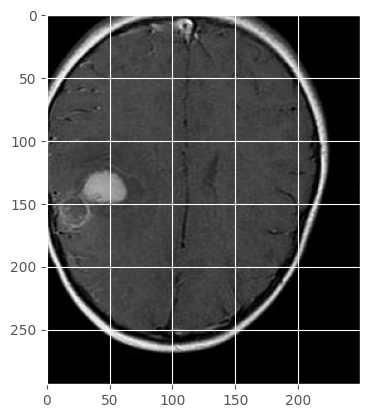

In [20]:
# Random Tumerous MRI Scan from Validation Set

import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt # Import matplotlib
from pylab import *

img = Image.open(r"/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation/tumerous/aug_Y_133_0_2078.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
imshow(img)
test_tumerous = tf.keras.utils.load_img('/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation/tumerous/aug_Y_133_0_2078.jpg', target_size = (128,128))
test_tumerous = np.expand_dims(test_tumerous, axis=0)
result = model.predict(test_tumerous)
validation_generator.class_indices
if result[0][0] == 1:
    prediction = 'This MRI shows a tumor'
else:
    prediction = 'this is a non-tumorous MRI'
print(prediction)

1/1 [==============================] - 0s 26ms/step
non-tumerous


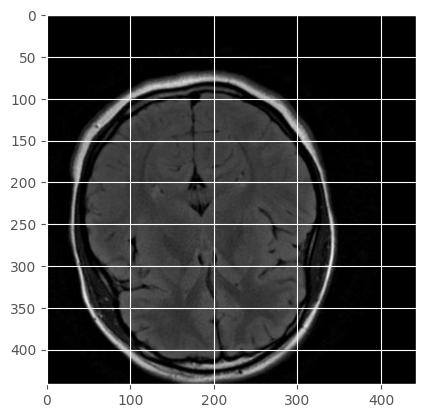

In [21]:
# Random Non_Tumerous MRI Scan from Validation Set

import numpy as np
from keras.preprocessing import image

img = Image.open(r"/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation/non_tumerous/aug_N_85_0_901.jpg")
x = np.array(img.resize((128,128)))
imshow(img)
test_tumerous = tf.keras.utils.load_img('/Gdrive/BTDv2/data/tumerous_and_nontumerous/validation/non_tumerous/aug_N_85_0_901.jpg', target_size = (128,128))
test_tumerous = np.expand_dims(test_tumerous, axis=0)
result = model.predict(test_tumerous)
validation_generator.class_indices
if result[0][0] == 1:
    prediction = 'tumerous'
else:
    prediction = 'non-tumerous'
print(prediction)

# 15) Saving the CNN Model

In [ ]:
from keras.models import load_model

MODEL_PATH = './drive/My Drive/brain_tumor_Detector.h5'

# Now save model in drive
model.save(MODEL_PATH)

# Load Model
model = load_model(MODEL_PATH)